In [ ]:
!git clone https://github.com/anm-ol/DreamLab
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p DreamLab/data/video
!mkdir -p DreamLab/data/mario
!mkdir -p DreamLab/weights
!cp drive/MyDrive/data/videos/mario_gameplay.mp4 DreamLab/data/video/mario_gameplay.mp4
%cd DreamLab

In [93]:
from src.data import *
extract_frames('data/video/mario_gameplay.mp4', 400, 1400, 2, 'data/mario', size=(256, 256))
split_data2('data/mario', test_split=0.2, num_frames=1)

Total frames in video: 69878


In [12]:
from src.data import videoDataset
from torch.utils.data import DataLoader
dataset = videoDataset('data/mario', 'data/train.txt', (256, 256))
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

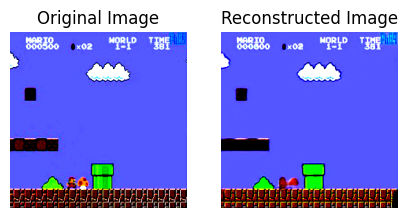

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from src.autoencoder import *
myvae = vae().to(device)
myvae.load_state_dict(torch.load('weights/simplevae_weights.pth'))
dataset = torch.load('weights/dataset.pth')
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
sample_image(myvae, dataset, 0)

In [10]:
from src.utils import *
dit = DiT(num_dit_blocks=12, patch_size=2, dims=512).to(device)
count_parameters(dit)

67.620096M


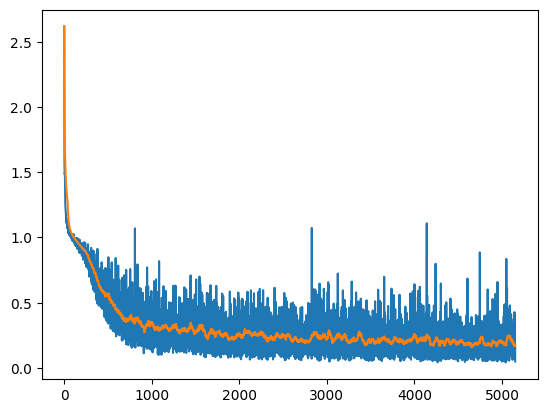

In [14]:
train_denoiser(dit, myvae, dataloader, num_steps=1000, lr=1e-5, num_epochs=50, scheduler='cosine')


In [3]:
dit, _= load_model_with_config('weights/dit_config.pth')
dit = dit.to(device)

In [40]:
config = {
    'num_dit_blocks': 8,
    'patch_size': 2,
    'dims': 1024,
    'scheduler': 'linear'
}
save_model_with_config(dit, 'weights/dit_config.pth', config, myvae)

In [33]:
dit.load_state_dict(torch.load('weights/dit8x_step1000patch2linear.pth'))

<All keys matched successfully>

In [ ]:
from src.utils import *
from src.autoencoder import *
from src.data import *
from torch.utils.data import DataLoader
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dit = load_model_with_config('weights/dit_config.pth')[0].to(device)
dataset = torch.load('weights/dataset.pth')
myvae = vae().to(device)
myvae.load_state_dict(torch.load('weights/simplevae_weights.pth'))
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

result = diffusion_sampler(myvae, dit, dataset, num_samples=8, num_steps=1000, scheduler='linear')